In [2]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from utils import * 
import xarray

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

2022-12-04 13:45:02.998125: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h2>Prepare Training and Test Sets</h2>

In [3]:
## Define paths to training and test data
cwd = os.getcwd()
train_path = "data/train/"
test_path = "data/test/"

# Training set
train_files    = ["mantua_pt"]
X_train_xr, _  = prepare_predictor(train_files,train_path)
y_train_xr, _  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('water_pt', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('water_pt',data_path=test_path,time_reindex=False)

## Convert to numpy arrays and check to make sure shapes of each dataset match
X_train = pd.DataFrame({"ssrd": X_train_xr["ssrd"].stack(dim=["time","latitude", "longitude"]).data,
                           #"tcc": X_train_xr["tcc"].stack(dim=["time","latitude", "longitude"]).data,
                           #"t2m": X_train_xr["t2m"].stack(dim=["time","latitude", "longitude"]).data
                          }, index=X_train_xr["ssrd"].coords['time'].data).fillna(0).to_numpy()

X_test  = pd.DataFrame({"ssrd": X_test_xr["ssrd"].stack(dim=["time","latitude", "longitude"]).data,
                           #"tcc": X_test_xr["tcc"].stack(dim=["time","latitude", "longitude"]).data,
                           #"t2m": X_train_xr["t2m"].stack(dim=["time","latitude", "longitude"]).data
                          }, index=X_test_xr["ssrd"].coords['time'].data).fillna(0).to_numpy()

y_train = y_train_xr["poa"].stack(dim=["latitude", "longitude"]).fillna(0).to_numpy()
y_test = y_test_xr["poa"].stack(dim=["latitude", "longitude"]).fillna(0).to_numpy()

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(11191, 1) (11191, 1) (11191, 1) (11191, 1)


In [5]:
print(X_train.shape, X_test.shape)

# Confirm no nan values
print(np.count_nonzero(np.isnan(y_test)))
np.count_nonzero(np.isnan(np.log(y_train + 1)))

null = pd.DataFrame(y_test)
null[null[0].isnull()]

(11191, 1) (11191, 1)
0


,0


In [6]:
# Standardization
X_train_log = np.log(X_train + 1)
assert(np.count_nonzero(np.isnan(X_train_log)) == 0)
X_test_log = np.log(X_test + 1)
assert(np.count_nonzero(np.isnan(X_test_log)) == 0)
y_train_log = np.log(y_train + 1)
assert(np.count_nonzero(np.isnan(y_train_log)) == 0)
y_test_log = np.log(y_test + 1)
assert(np.count_nonzero(np.isnan(y_test_log)) == 0)

# instead of xtrain mean, i would have to calculate the means for each variable seperately
mean, std = X_train_log.mean(), X_train_log.std()

X_train_log   = (X_train_log - mean)/std
X_test_log    = (X_test_log - mean)/std


y_mean, y_std = y_train_log.mean(), y_train_log.std()

y_train_log = (y_train_log - y_mean) / y_std
y_test_log = (y_test_log - y_mean) / y_std

print(X_train_log.shape,y_train_log.shape)
print(X_test_log.shape,y_test_log.shape)


(11191, 1) (11191, 1)
(11191, 1) (11191, 1)


In [7]:
# set hyperparameters
n_neuron       = 128
activation     = 'relu'
num_epochs     = 100
learning_rate  = 0.001
minibatch_size = 16
model_num      = 1

#create the model
model = Sequential()

model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
model.add(Dense(y_train.shape[1],  activation='linear')) # the output layer

model.compile(loss='mse',optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               256       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 33,409
Trainable params: 33,409
Non-trainable params: 0
_________________________________________________________________


2022-12-04 13:45:12.463245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
print('\nInital test eval on different site:')
model.evaluate(X_test_log, y_test_log)

history = model.fit(X_train_log, y_train_log, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split = 0.4,
                    verbose         = 1,
                    callbacks       = [early_stop])

print('\nFinal test eval on different site:')
model.evaluate(X_test_log, y_test_log)



Inital test eval on different site:
350/350 [==============================] - 0s 506us/step - loss: 0.8108
Epoch 1/100
420/420 [==============================] - 1s 961us/step - loss: 0.6390 - val_loss: 0.3978
Epoch 2/100
420/420 [==============================] - 0s 987us/step - loss: 0.2475 - val_loss: 0.2374
Epoch 3/100
420/420 [==============================] - 0s 893us/step - loss: 0.1893 - val_loss: 0.2197
Epoch 4/100
420/420 [==============================] - 0s 900us/step - loss: 0.1788 - val_loss: 0.2096
Epoch 5/100
420/420 [==============================] - 0s 868us/step - loss: 0.1712 - val_loss: 0.2023
Epoch 6/100
420/420 [==============================] - 0s 869us/step - loss: 0.1651 - val_loss: 0.1969
Epoch 7/100
420/420 [==============================] - 0s 866us/step - loss: 0.1597 - val_loss: 0.1916
Epoch 8/100
420/420 [==============================] - 0s 861us/step - loss: 0.1550 - val_loss: 0.1874
Epoch 9/100
420/420 [==============================] - 0s 870us/ste

0.19555853307247162

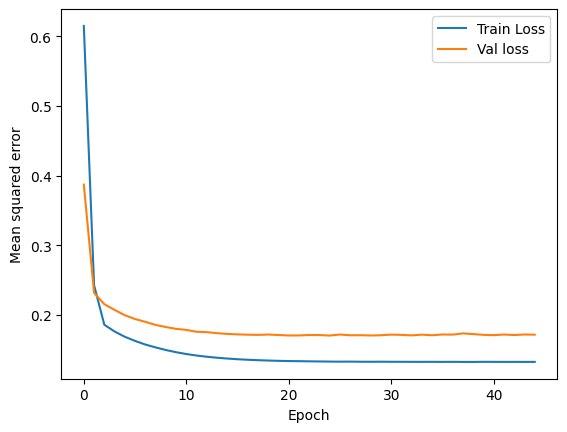

In [130]:
plot_history(history)

350/350 [==============================] - 0s 466us/step


Text(0, 0.5, 'y')

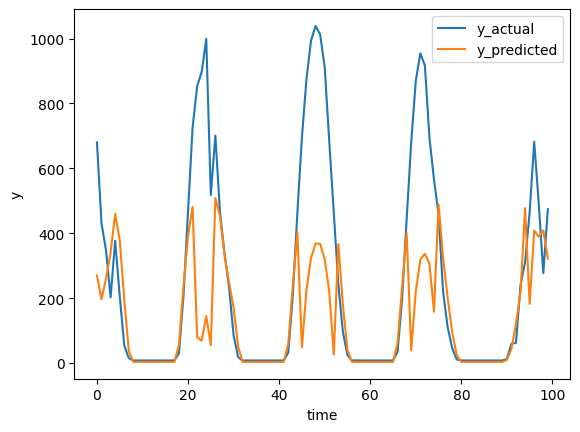

In [132]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'NN_model.h5'))

# reload the saved model
model = load_model(os.path.join(model_path,'NN_model.h5'))

#y_Test 
y_test_predict_log = model.predict(X_test_log)
y_test_predict = np.exp(y_test_predict_log* y_std + y_mean) - 1

df_test = pd.DataFrame()
df_test["y_test_log"] = y_test_log[:, 0]
df_test["y_test_log_predict"] = y_test_predict_log
df_test["y_test"] = y_test[:, 0]
df_test["y_test_predict"] = y_test_predict

df_plot = df_test[0:100]
plt.plot(df_plot.y_test,label="y_actual")
plt.plot(df_plot.y_test_predict,label="y_predicted")
plt.xlabel("time")
plt.legend()
plt.ylabel("y")

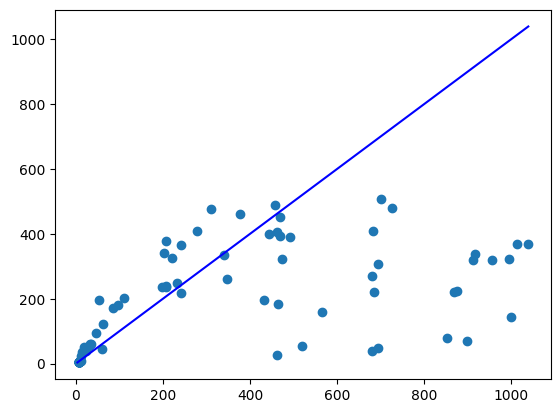

In [139]:
plt.scatter(x=df_plot.y_test,y=df_plot.y_test_predict)
p1 = max(max(df_plot.y_test_predict), max(df_plot.y_test))
p2 = min(min(df_plot.y_test_predict), min(df_plot.y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.show()


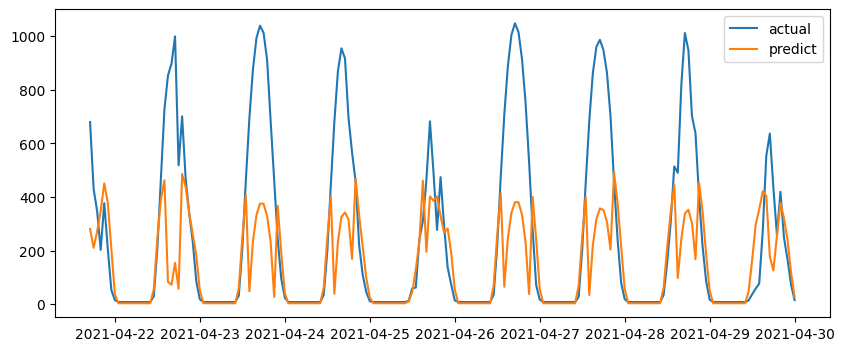

In [87]:

plt.figure(figsize=(10,4))
df_plot = df_test[0:200]
plt.plot(df_plot.y_actual,label="actual")
plt.plot(df_plot.y_predict,label="predict")
plt.legend()